In [160]:
"""
Plotting model results for Washington, D.C. and Denver, Colorado roof material mapping

See also "04resnet18-cv-training-{AOI}.ipynb". Plots here are for manuscript preparation.

Author: maxwell.cook@colorado.edu
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import precision_recall_curve, auc

plt.rcParams['font.family'] = 'Times New Roman'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Imports successful !")

Imports successful !


In [2]:
# Load the model results for both models and AOIs

# Resnet-18
fp_dc = os.path.join(maindir, 'results/resnet18/cv-results/dc-resnet18_cv_fold_results.csv')
fp_denver = os.path.join(maindir, 'results/resnet18/cv-results/denver-resnet18_cv_fold_results.csv')
# Store in a dictionary for access
r18_results = {
    'dc': pd.read_csv(fp_dc),
    'denver': pd.read_csv(fp_denver)
}

# XGBoost
fp_dc = os.path.join(maindir, 'results/xgboost/dc_xgboost_folds_results.csv')
fp_denver = os.path.join(maindir, 'results/xgboost/denver_xgboost_folds_results.csv')
xgb_results = {
    'dc': pd.read_csv(fp_dc),
    'denver': pd.read_csv(fp_denver)
}

print("Model results loaded !")

Model results loaded !


In [60]:
# Load the classification report data, create average across folds
dc_fp = os.path.join(maindir, 'results/resnet18/cv-results/dc-resnet18_cv_classification_reports.csv')
denver_fp = os.path.join(maindir, 'results/resnet18/cv-results/denver-resnet18_cv_classification_reports.csv')
cr_reports = {
    'dc': pd.read_csv(dc_fp),
    'denver': pd.read_csv(denver_fp)
}

# Average reports across folds:
cr_summaries = {}
for aoi, cr in cr_reports.items():
    # Calculate the mean metrics across all folds
    cr_summary = cr[['class_code', 'precision', 'recall', 'f1-score']].groupby('class_code').agg(['mean', 'std']).reset_index()
    cr_summary.columns = ['class_code', 'precision', 'precision_sd', 
                          'recall', 'recall_sd', 
                          'f1-score', 'f1-score_sd']
    cr_summaries[aoi] = cr_summary

print("Classification report data loaded !")

Classification report data loaded !


In [61]:
results_dir = os.path.join(maindir, 'results/figures/')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(results_dir)

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/results/figures/


In [ ]:
# Create a consistent color mapping for roof material classes in both AOIs
all_classes = set()
for cr in cr_summaries.values():
    all_classes.update(cr['class_code'].unique())
# Sort alphabetically and assign a color map
all_classes = sorted(all_classes)  # Sort for consistent ordering
class_palette = sns.color_palette('husl', len(all_classes))
color_mapping = dict(zip(all_classes, class_palette))
print(color_mapping)

In [4]:
# Model Loss Functions and Validation F1-score across across epochs, average holdout F1-score by class

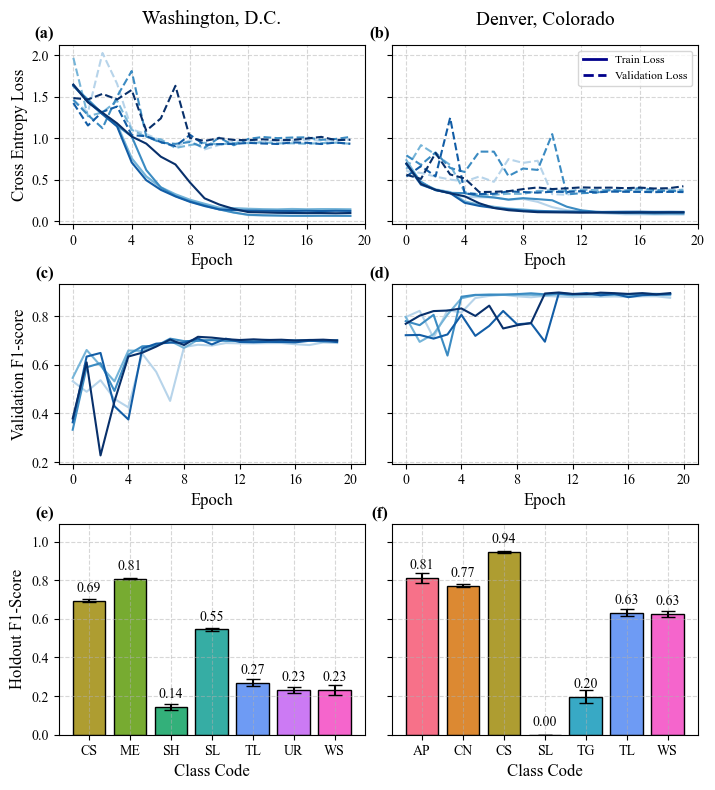

In [122]:
# Set up the combined 3x2 subplots

fig, axes = plt.subplots(3, 2, figsize=(7.25, 8), sharey='row', gridspec_kw={'height_ratios': [0.85, 0.85, 1]}) 
plt.rcParams['font.family'] = 'Times New Roman'

# Adjust spacing 
# fig.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.1, hspace=0.3, wspace=0.3)

# Plot 1: Train/Validation Loss (top left, top right)
for idx, (aoi, fold_results_df) in enumerate(r18_results.items()):
    ax = axes[0, idx]  # First row (0) for the first plot
    
    # Extract the average validation loss for each fold
    fold_avg_val_loss = fold_results_df.groupby('fold_id')['epoch_val_loss'].min().reset_index()
    # Sort by the validation loss to determine the order of shading
    sorted_folds = fold_avg_val_loss.sort_values(by='epoch_val_loss', ascending=True)['fold_id'].values
    # Create a color gradient from light to dark blue
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_folds)))  # Adjust the range for a clearer gradient

    # Plot train and validation loss for each fold in the order of sorted validation loss
    for idx, fold_idx in enumerate(sorted_folds):
        fold_data = fold_results_df[fold_results_df['fold_id'] == fold_idx]
        epoch_train_losses = fold_data['epoch_train_loss'].values
        epoch_val_losses = fold_data['epoch_val_loss'].values

        # Plot train/val loss with the corresponding color
        ax.plot(epoch_train_losses, color=colors[idx], linestyle='-')
        ax.plot(epoch_val_losses, color=colors[idx], linestyle='--')

    # Add labels and grid
    ax.set_xlim(-1, 20)
    ax.set_xticks([0, 4, 8, 12, 16, 20])
    ax.set_xlabel('Epoch', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.set_title('Washington, D.C.' if aoi == 'dc' else 'Denver, Colorado', size=14, pad=15)

axes[0,0].set_ylabel('Cross Entropy Loss', fontsize=12)
axes[0,0].yaxis.set_label_coords(-0.1, 0.5)

# Add legend for only train and validation loss on the top right subplot
dark_blue = '#00008B'
train_line = plt.Line2D([0], [0], color=dark_blue, lw=2, linestyle='-')
val_line = plt.Line2D([0], [0], color=dark_blue, lw=2, linestyle='--')
axes[0, 1].legend([train_line, val_line], ['Train Loss', 'Validation Loss'], loc='upper right', fontsize='small')

# Plot 2: Validation F1-Score (middle left, middle right)
for idx, (aoi, fold_results_df) in enumerate(r18_results.items()):
    ax = axes[1, idx]  # Second row (1) for the second plot
    
    # Extract the average F1-score for each fold
    fold_avg_f1 = fold_results_df.groupby('fold_id')['val_f1'].max().reset_index()
    sorted_folds = fold_avg_f1.sort_values(by='val_f1', ascending=True)['fold_id'].values
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_folds)))  # Adjust the range for a clearer gradient

    # Plot F1-score for each fold
    for idx, fold_idx in enumerate(sorted_folds):
        fold_data = fold_results_df[fold_results_df['fold_id'] == fold_idx]
        epoch_f1 = fold_data['val_f1'].values
        ax.plot(epoch_f1, color=colors[idx], linestyle='-')

    # Add labels and grid
    ax.set_xlim(-1, 21)
    ax.set_xticks([0, 4, 8, 12, 16, 20])
    ax.set_xlabel('Epoch', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

axes[1,0].set_ylabel('Validation F1-score', fontsize=12)
axes[1,0].yaxis.set_label_coords(-0.1, 0.5)

# Plot 3: Holdout F1-Score (bottom left, bottom right)
for idx, (aoi, cr_summary) in enumerate(cr_summaries.items()):
    # Sort the data by F1-score
    cr_summary = cr_summary.sort_values(by='class_code', ascending=True)
    ax = axes[2, idx]  # Third row (2) for the third plot
    # Apply color mapping
    bar_colors = [color_mapping[label] for label in cr_summary['class_code']]
    
    # Create the bar plot with error bars
    bars = ax.bar(cr_summary['class_code'], cr_summary['f1-score'], 
                  yerr=cr_summary['f1-score_sd'], capsize=5, color=bar_colors, edgecolor='black')
    
    # Add the mean F1-score labels above the bars
    for bar, f1_mean in zip(bars, cr_summary['f1-score']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.03, f'{f1_mean:.2f}', 
                ha='center', va='bottom', fontsize=10, color='black')
    
    # Set labels and title
    ax.set_xlabel('Class Code', fontsize=12)
    if idx == 0:
        ax.set_ylabel('Holdout F1-Score', fontsize=12)
    
    # Add gridlines for better readability
    ax.grid(True, linestyle='--', alpha=0.5)

    # Add margins for upper spacing
    ax.margins(y=0.15)
    
# Add subplot indicators outside the plot area
fig.text(0.068, 0.96, '(a)', fontsize=12, fontweight='bold', ha='center', va='top')  # Top left
fig.text(0.53, 0.96, '(b)', fontsize=12, fontweight='bold', ha='center', va='top')   # Top right

fig.text(0.068, 0.66, '(c)', fontsize=12, fontweight='bold', ha='center', va='top')  # Bottom left
fig.text(0.53, 0.66, '(d)', fontsize=12, fontweight='bold', ha='center', va='top')   # Bottom right

fig.text(0.068, 0.36, '(e)', fontsize=12, fontweight='bold', ha='center', va='top')  # Bottom left (Holdout F1-score)
fig.text(0.53, 0.36, '(f)', fontsize=12, fontweight='bold', ha='center', va='top')   # Bottom right (Holdout F1-score)

# Tighten layout and save
plt.tight_layout()
fig_out = os.path.join(results_dir, 'resnet18-cv_epoch_trainval_loss_f1score.png')
plt.savefig(fig_out, dpi=300, bbox_inches='tight')

plt.show()

In [8]:
# Correct / Total Holdout

In [124]:
# Load the holdout data

dc_fp = os.path.join(maindir, 'results/resnet18/cv-results/dc-resnet18_cv_holdout_preds.csv')
denver_fp = os.path.join(maindir, 'results/resnet18/cv-results/denver-resnet18_cv_holdout_preds.csv')

r18_holdout = {
    'dc': pd.read_csv(dc_fp),
    'denver': pd.read_csv(denver_fp)
}

print("Data loaded !")

Data loaded !


In [125]:
r18_holdout['dc'].head()

,fold_idx,true_code,pred_code,true_label,pred_label
0,1,0,0,CS,CS
1,1,0,0,CS,CS
2,1,0,2,CS,SL
3,1,0,0,CS,CS
4,1,0,2,CS,SL


In [11]:
pred_dfs = {}
for aoi, pred_df in r18_holdout.items():
    # Count the number of correct
    pred_df['correct'] = pred_df['true_label'] == pred_df['pred_label']
    correct_df = pred_df.groupby(['fold_idx', 'true_label']).agg(correct_count=('correct', 'sum')).reset_index()
    correct_df = correct_df.groupby('true_label')['correct_count'].agg(['mean', 'std']).reset_index()
    # Get total counts of true labels
    total_counts = pred_df.groupby(['fold_idx', 'true_label']).size().reset_index(name='total_count')
    total_counts_mn = total_counts.groupby('true_label')['total_count'].mean().reset_index()
    # Merge back to data frame
    pred_dfs[aoi] = correct_df.merge(total_counts_mn, on='true_label', how='left')
print(pred_dfs['dc'])

  true_label    mean        std  total_count
0         CS  4546.4  88.984830       7427.0
1         ME  5586.4  69.063739       7373.0
2         SH    35.8   3.271085        157.0
3         SL  2000.4  28.147824       3054.0
4         TL    75.0   6.204837        185.0
5         UR   148.8   7.854935        256.0
6         WS    88.4   7.021396        231.0


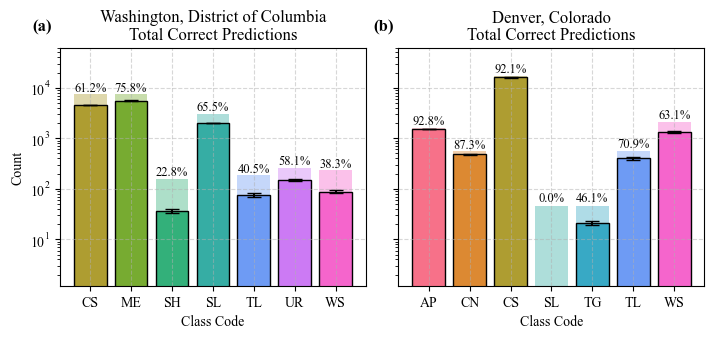

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.75), sharey=True)

# Iterate over the AOIs to populate the subplots for total correct predictions
for idx, (aoi, preds_df) in enumerate(pred_dfs.items()):
    # Calculate percentage correct
    preds_df['percent_correct'] = (preds_df['mean'] / preds_df['total_count']) * 100

    # Extract the current subplot axis
    ax = axes[idx]

    # Apply color mapping to the bars
    bar_colors = [color_mapping[label] for label in preds_df['true_label']]
    
    # Plot total counts and correct counts
    total_bars = ax.bar(preds_df['true_label'], preds_df['total_count'], color=bar_colors, alpha=0.4, label='Total Samples')
    correct_bars = ax.bar(preds_df['true_label'], preds_df['mean'], yerr=preds_df['std'], 
                          capsize=5, color=bar_colors, edgecolor='black', label='Correct Predictions')
    
    # Add percentage labels above the total count bars
    for total_bar, percent in zip(total_bars, preds_df['percent_correct']):
        height = total_bar.get_height()
        ax.text(total_bar.get_x() + total_bar.get_width() / 2, height + 2, f'{percent:.1f}%', 
                ha='center', va='bottom', fontsize=9, color='black')
    
    # Set labels and title
    ax.set_xlabel('Class Code')
    if idx == 0:
        ax.set_ylabel('Count')
    if aoi == 'dc':
        title = 'Washington, District of Columbia'
    elif aoi == 'denver':
        title = 'Denver, Colorado'
    ax.set_title(f'{title}\nTotal Correct Predictions')
    # ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    # Apply log scale to y-axis
    plt.yscale('log')
    
    ax.margins(y=0.15) # add some upper spacing

# Add subplot indicators outside the plot area
fig.text(0.08, 0.90, '(a)', fontsize=12, fontweight='bold', ha='center', va='top')  # Adjust coordinates if needed
fig.text(0.535, 0.90, '(b)', fontsize=12, fontweight='bold', ha='center', va='top')  # Adjust coordinates if needed

# Adjust layout and save the figure
fig.tight_layout(pad=2.0)
fig_out = os.path.join(results_dir, 'resnet18-cv_total_correct_by_class.png')
fig.savefig(fig_out, dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Roof material class AUC-PR for both models (ResNet-18 and XGBoost) and AOIs

In [162]:
def calc_auc_pr(df, class_code, true_col):
    """ 
    Function to calculate the AUC-PR curve for a given roof material class
    Args:
        df: the dataframe containing class probabilities and true labels
        class_code: the roof material class to calculate the AUC-PR curve for
        true_col: column in the dataframe with the true class label
        prob_col: column in the dataframe with the predicted probability for that class
    Returns: AUC-PR curve
    """
    # Get true labels and predicted probabilities for the given class
    true_labels = df[true_col] == class_code
    probs = df[class_code]
    
    # Compute Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    auc_pr = auc(recall, precision) # Compute AUC-PR
    
    return precision, recall, auc_pr

In [167]:
# Load the ResNet-18 model predictions
dc_fp = os.path.join(maindir, 'results/resnet18/cv-results/dc-resnet18_cv_holdout_prob_preds.csv')
denver_fp = os.path.join(maindir, 'results/resnet18/cv-results/denver-resnet18_cv_holdout_prob_preds.csv')

r18_prob_preds = {
    'dc': pd.read_csv(dc_fp),
    'denver': pd.read_csv(denver_fp)
}

# Assign a color for each AOI
aoi_color_map = {'dc': 'purple', 'denver': 'darkgreen'}

print("Data loaded !")

Data loaded !


In [200]:
# Load the XGBoost model predictions
xgb_dc_fp = os.path.join(maindir, 'results/xgboost-cv/dc-xgboost-cv_fold_pred_probs.csv')
xgb_denver_fp = os.path.join(maindir, 'results/xgboost-cv/denver-xgboost-cv_fold_pred_probs.csv')

xgb_prob_preds = {
    'dc': pd.read_csv(xgb_dc_fp),
    'denver': pd.read_csv(xgb_denver_fp)
}

print("Data loaded !")

Data loaded !


In [201]:
shared_classes = set(r18_prob_preds['dc']['true_label']).intersection(r18_prob_preds['denver']['true_label'])
dc_only = set(r18_prob_preds['dc']['true_label']) - shared_classes
denver_only = set(r18_prob_preds['denver']['true_label']) - shared_classes
print(f"D.C. only classes: {dc_only}\nDenver only classes: {denver_only}\nShared classes: {shared_classes}\nAll classes: {all_classes}")

D.C. only classes: {'UR', 'ME', 'SH'}
Denver only classes: {'AP', 'TG', 'CN'}
Shared classes: {'TL', 'SL', 'WS', 'CS'}
All classes: ['AP', 'CN', 'CS', 'ME', 'SH', 'SL', 'TG', 'TL', 'UR', 'WS']


In [202]:
print(xgb_prob_preds['dc'].head())

   Unnamed: 0  fold_idx  true_code  pred_code true_label pred_label        CS  \
0           0         1          0          0         CS         CS  0.244081   
1           1         1          0          0         CS         CS  0.198814   
2           2         1          0          4         CS         TL  0.158815   
3           3         1          0          0         CS         CS  0.260729   
4           4         1          0          2         CS         SL  0.136481   

         ME        SL        UR        TL        WS        SH  
0  0.102749  0.128716  0.092079  0.120637  0.177926  0.133813  
1  0.148781  0.156685  0.091495  0.142961  0.117193  0.144072  
2  0.099323  0.163106  0.091547  0.227949  0.129524  0.129736  
3  0.089806  0.161800  0.086586  0.116693  0.151523  0.132863  
4  0.087622  0.288528  0.086799  0.141159  0.139450  0.119961  


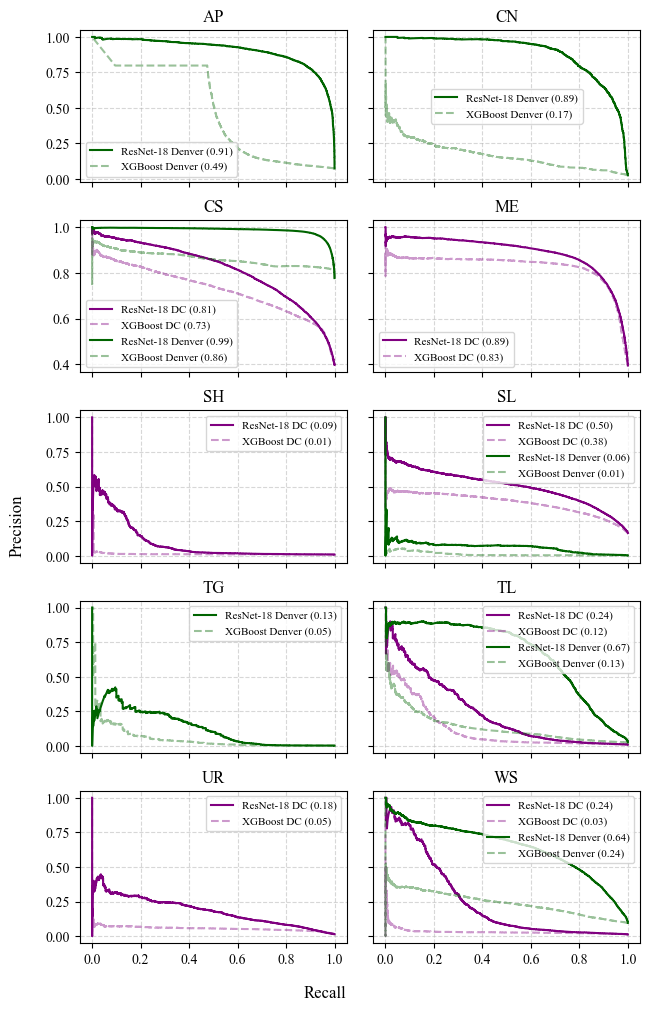

In [208]:
fig, axes = plt.subplots(nrows=int(len(all_classes)/2), ncols=2, figsize=(7, 11), sharey='row', sharex='col')

for idx, label in enumerate(all_classes):
    row, col = divmod(idx, 2)  # Organize into 2 columns
    ax = axes[row, col]

    # Plot for D.C. ResNet-18
    if label in set(r18_prob_preds['dc']['true_label'].unique()):
        precision, recall, auc_pr = calc_auc_pr(r18_prob_preds['dc'], label, 'true_label')
        ax.plot(recall, precision, label=f'ResNet-18 DC ({auc_pr:.2f})', color=aoi_color_map['dc'])

    # Plot for D.C. XGBoost
    if label in set(xgb_prob_preds['dc']['true_label'].unique()):
        precision, recall, auc_pr = calc_auc_pr(xgb_prob_preds['dc'], label, 'true_label')
        ax.plot(recall, precision, label=f'XGBoost DC ({auc_pr:.2f})', color=aoi_color_map['dc'], linestyle='--', alpha=0.4)

    # Plot for Denver ResNet-18
    if label in set(r18_prob_preds['denver']['true_label'].unique()):
        precision, recall, auc_pr = calc_auc_pr(r18_prob_preds['denver'], label, 'true_label')
        ax.plot(recall, precision, label=f'ResNet-18 Denver ({auc_pr:.2f})', color=aoi_color_map['denver'])

    # Plot for Denver XGBoost
    if label in set(xgb_prob_preds['denver']['true_label'].unique()):
        precision, recall, auc_pr = calc_auc_pr(xgb_prob_preds['denver'], label, 'true_label')
        ax.plot(recall, precision, label=f'XGBoost Denver ({auc_pr:.2f})', color=aoi_color_map['denver'], linestyle='--', alpha=0.4)
    
    # Set labels and title
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(label)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

fig.text(0.05, 0.5, 'Precision', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.07, 'Recall', ha='center', fontsize=12)

fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12, hspace=0.25, wspace=0.1)
# plt.tight_layout()

fig_out = os.path.join(results_dir, 'resnet18-xgboost-cv_AUCPR.png')
fig.savefig(fig_out, dpi=300, bbox_inches='tight')

plt.show()